In [1]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


## Sky Positions

In [38]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from analysis_tools_cython import *
import tqdm as tqdm

In [3]:
def get_output(file_path):
    """Imports batch_analyse output file as pandas dataframe."""
    with open(file_path) as f:
        lines = f.readlines()
    lc_lists = [word for line in lines for word in line.split()]
    lc_lists = [lc_lists[i:i+10] for i in range(0, len(lc_lists), 10)]
    cols = ['file','signal','signal/noise','time','asym_score','width1','width2','duration','depth','transit_prob']
    df = pd.DataFrame(data=lc_lists,columns=cols)
    df[cols[1:-1]] = df[cols[1:-1]].astype('float32')
    return df

def filter_df(df,min_asym_score=1.0,max_asym_score=2.0,duration=0.5,signal=-5.0):
    """filters df for given parameter range.
    Default settings:
    - `signal/noise` greater than 5.
        - Minimum test statistic is always negative. We flip the sign in plots for convenience.
    - `duration` set to greater than 0.5 days.
    - `asym_score` between 1.00 to 2.0.
    """
    return df[(df.duration >= duration) & (df['signal/noise'] <= signal) & (df['asym_score'] >= min_asym_score) & (df['asym_score'] <= max_asym_score)]


In [26]:
df = get_output('output_xrp_s6.txt')
filtered_df = filter_df(df)
table = Table.from_pandas(filtered_df)

In [20]:
path = '/storage/astro2/phrdhx/tesslcs'
sector = 6

In [92]:
tic_id = []
ra_rad = []
dec_rad = []
for i in filtered_df.file:
    file_paths = glob.glob(os.path.join(path,f'**/**/{i}'))[0]
    ref = pd.read_pickle(glob.glob(os.path.join(path,f'**/**/{i}'))[0])
    table = import_XRPlightcurve(file_paths,sector=sector,drop_bad_points=True)[0] # drop_bad_points is True
    store = import_XRPlightcurve(file_paths,sector=sector,drop_bad_points=True)[1]
    tic = store[0]
    ra = store[1] * u.degree
    dec = store[2] * u.degree
    c = SkyCoord(ra=ra, dec=dec, frame='icrs')
    ra_rad.append(c.ra.wrap_at(180 * u.deg).radian)
    dec_rad.append(c.dec.radian)

In [93]:
box = df[(df['signal/noise'] <= -7.4) & (df['asym_score'] >= 1.30) & (df['transit_prob'] == 'maybeTransit') & (df['asym_score'] <= 1.60) & (df['signal/noise'] >= -12)]
to_import = box['file']

In [ ]:
box_ra_rad = []
box_dec_rad = []
for i in to_import:
    file_paths = glob.glob(os.path.join(path,f'**/**/{i}'))[0]
    ref = pd.read_pickle(glob.glob(os.path.join(path,f'**/**/{i}'))[0])
    table = import_XRPlightcurve(file_paths,sector=sector,drop_bad_points=True)[0] # drop_bad_points is True
    store = import_XRPlightcurve(file_paths,sector=sector,drop_bad_points=True)[1]
    box_tic = store[0]
    ra = store[1] * u.degree
    dec = store[2] * u.degree
    d = SkyCoord(ra=ra, dec=dec, frame='icrs')
    box_ra_rad.append(d.ra.wrap_at(180 * u.deg).radian)
    box_dec_rad.append(d.dec.radian)

In [ ]:
plt.figure(figsize=(12,7))
plt.subplot(111, projection="aitoff")
plt.title("Aitoff projection of Sector 6 and the bad lightcurves")
plt.grid(True)
plt.plot(ra_rad, dec_rad, 'o', markersize=2, alpha=0.2)
plt.plot(box_ra_rad,box_dec_rad,'y', markersize=2, alpha=0.2)
plt.subplots_adjust(top=0.65,bottom=0.0)
plt.show()

In [ ]:
plt.subplot(111, projection="aitoff")
plt.plot(ra_rad, dec_rad, 'b', markersize=2, alpha=0.2)

---

In [ ]:
ra_rad

In [72]:
import lightkurve as lk

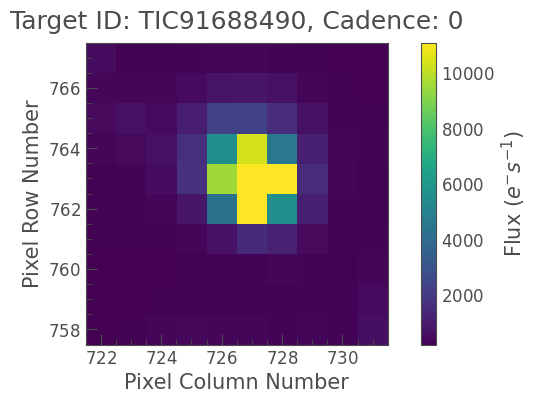

In [77]:
search_result = lk.search_tesscut('TIC91688490',sector=6).download(cutout_size=10)
search_result.plot()